# Examen Parcial 2


### About Dataset
Machine Predictive Maintenance Classification Dataset
Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

### Important : 
There are two Targets - Do not make the mistake of using one of them as feature, as it will lead to leakage.
- Target : Failure or Not
- Failure Type : Type of Failure


> **Nota importante:** Para este examen vamos a utilizar la variable objetivo, **Target** es binaria si la maquina fallo o no, la otra variable hay que eliminarla ya que puede causar data leakage

> **Pregunta 1:** Investigar y explicar en un parrafo en formato markdown que es el **data leakage** y como esta puede afectar a nuestro modelo de ML, especificamente en este caso porque hay que eliminar una de las variables objetivo

**¿Qué es el data leakage y cómo afecta a un modelo de ML?**

El *data leakage* pasa cuando un modelo aprende con información que no debería conocer, como datos del futuro o variables que están directamente relacionadas con lo que queremos predecir. Esto hace que el modelo parezca muy bueno al entrenarse, pero falle al aplicarse a nuevos datos. En este modelo específico, tener tanto la columna `Target` como `Failure Type` puede causar leakage, porque ambas contienen información del fallo. Para evitarlo, hay que elegir solo una como variable objetivo y eliminar la otra.

## Carga de datos

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("predictive_maintenance.csv")

In [ ]:
data

## Preprocesamiento de datos

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


### Validacion de datos Null o dupicados

In [6]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [7]:
data.duplicated().sum()

np.int64(0)

### Entendiendo los tipos de datos y valores unicos

In [8]:
data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [9]:
data.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

In [10]:
data['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

> **Pregunta 2:** Que entiendes de el analisis anterior

Del análisis previo, se puede concluir que los datos están limpios, ya que no hay valores nulos ni registros duplicados. A su vez, se pudo identificar los tipos de datos que tenemos tales como datos numéricos y categóricos.

Además, al observar los valores únicos, se nota que hay variables como `UDI` y `Product ID` que son identificadores únicos y probablemente no sean útiles para el modelo, por lo que es conveniente eliminarlos.

En la columna `Type` se encuentran tres tipos de productos: `L`, `M` y `H`, con una distribución desigual (mayoría de tipo `L`). Este desbalance es importante y se debe tomar en cuenta cuando entrenemos nuestro modelo, ya que puede afectar el rendimiento del clasificador.

### Eliminar identificadores
Elimina las variables
- UDI
- Product ID
- Failure Type


Tip: utiliza la función `drop`de pandas

In [15]:
print(data.columns.tolist())

['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target']


In [16]:
data = data.drop(columns=['UDI', 'Product ID', 'Failure Type'], errors='ignore')

### Verificamos si el dataset esta balancado

Tip: Utiliza la funcion de pandas `value_counts()` 

In [17]:
data['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

> **Pregunta 3:** Esta balanceado o no el dataset, que estrategias hay para un dataset no balanceado

Al revisar los valores de la variable `Target`, vemos que el dataset está desbalanceado: hay 9661 casos de clase 0 y solo 339 de clase 1. Esto puede ser un problema para entrenar nuestro modelo de Machine Learning, ya que pueden aprender a predecir siempre la clase mayoritaria y aún así tener buena precisión, sin realmente aprender a detectar la clase minoritaria.

Para lidiar con este desequilibrio, se pueden usar varias estrategias, como:
- **Submuestreo (undersampling):** de la clase mayoritaria.
- **Sobremuestreo (oversampling):** de la clase minoritaria, usando por ejemplo técnicas como SMOTE.
- **Ajustar los pesos del modelo:** para que preste más atención a la clase minoritaria.
- **Elegir métricas de evaluación más adecuadas:**, como `f1-score`, `recall` o `AUC`, en lugar de solo precisión.

### Creamos dos variables nuevas
- temperature_difference: diferencia entre la temperatura de el aire y la del proceso
- Mechanical Power (W):

$$
P = \frac{T \cdot 2\pi \cdot N}{60}
$$
Donde:

- $P$ es la potencia en W,
- $T$ es el torque en Nm,
- $N$ es la velocidad en rpm,
- $\frac{2\pi}{60}$ convierte rpm a rad/s.

Aplicandolo a la data:
$$
\text{Potencia (W)} = \frac{\text{Torque (Nm)} \cdot \text{Velocidad (rpm)} \cdot 2 \cdot \pi}{60.4}
$$

In [19]:
data['temperature_difference']= data['Process temperature [K]'] - data['Air temperature [K]']

In [20]:
data['Mechanical Power [W]']= (data['Torque [Nm]'] * data['Rotational speed [rpm]'] * 2 * np.pi) / 60

## Analisis de Datos Exploratorio

#### Visualización de Tipos de maquina
Grafica la distribución de tipos de maquina

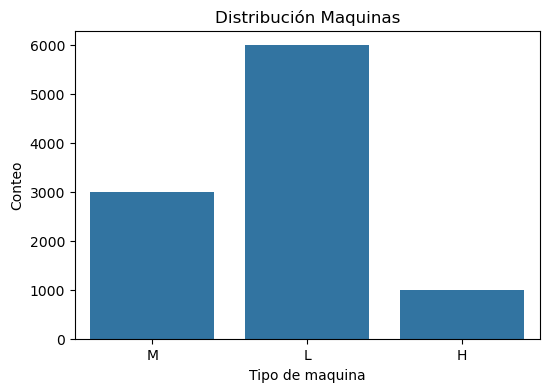

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', data=data)
plt.title('Distribución Maquinas')
plt.xlabel('Tipo de maquina')
plt.ylabel('Conteo')
plt.show()

#### Visualización de la distribución de fallos entre tipos de productos

Muestra cómo se distribuyen los fallos entre los tipos: ¿es posible que algunos tipos de maquina fallan más?

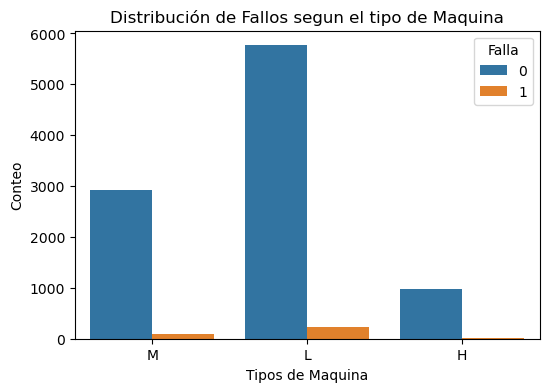

In [22]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', hue='Target', data=data)
plt.title('Distribución de Fallos segun el tipo de Maquina')
plt.xlabel('Tipos de Maquina')
plt.ylabel('Conteo')
plt.legend(title='Falla')
plt.show()

### Grafico de distribuciones 
Graficamos las distribuciones de las variables numericas para observar anomalias y patrones en los datos.



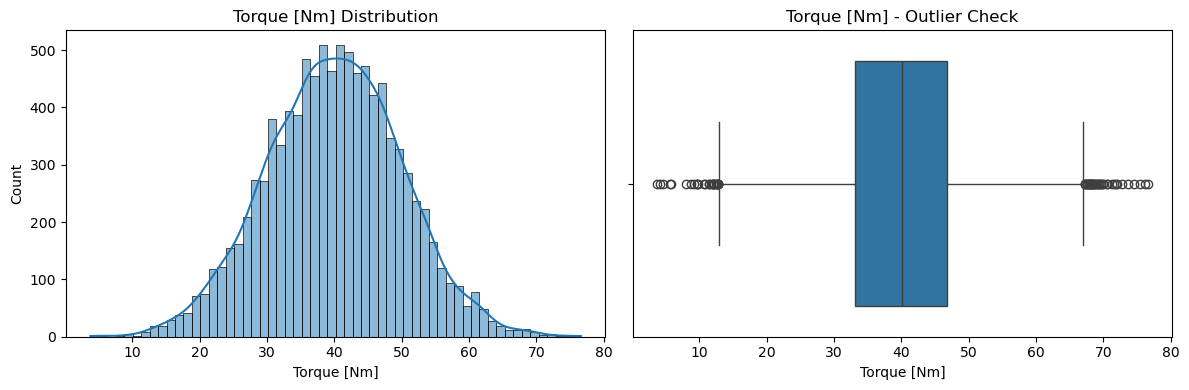

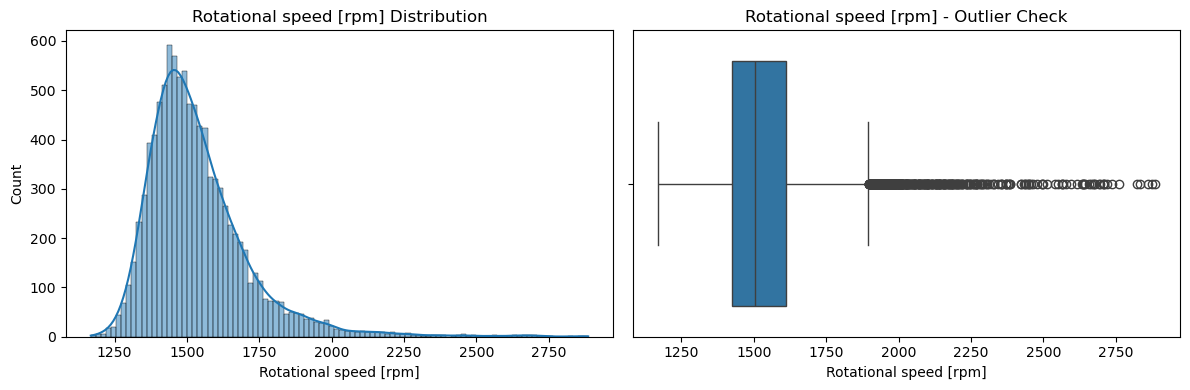

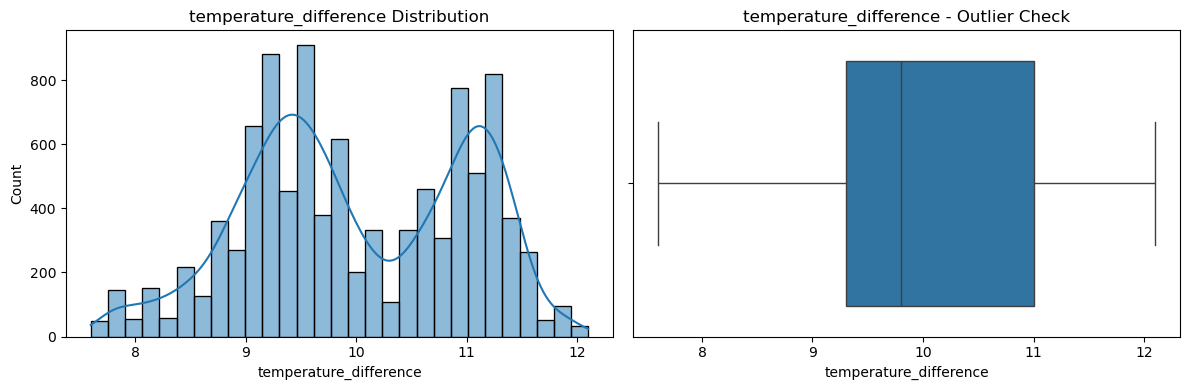

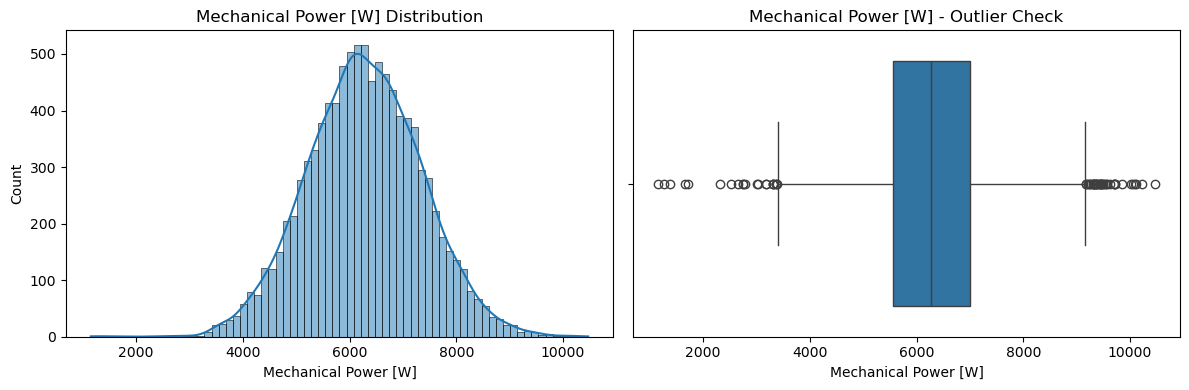

In [24]:
cols = [
    'Torque [Nm]', 'Rotational speed [rpm]', 
    'temperature_difference', 'Mechanical Power [W]'
]

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

    # Histogram with KDE
    sns.histplot(data=data, x=col, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} Distribution")

    # Boxplot
    sns.boxplot(data=data, x=col, ax=axes[1])
    axes[1].set_title(f"{col} - Outlier Check")

    plt.tight_layout()
    plt.show()

> **Pregunta 4:** Describe que entiendes de la grafica anterior

#### Torque [Nm]
- **Histograma:** La forma es bastante simétrica, similar a una campana. La mayoría de los valores se agrupan entre 30 y 50 Nm, con un pico claro cerca de los 40 Nm.
- **Boxplot:** Aunque la distribución se ve normal, aparecen muchos valores atípicos (outliers) a ambos extremos. Esto podría representar condiciones especiales o errores que sería bueno revisar antes de modelar.


#### Rotational speed [rpm]
- **Histograma:** Está sesgado hacia la derecha. Se observa una gran concentración de datos entre 1300 y 1700 rpm. Luego, los valores disminuyen de forma más gradual.
- **Boxplot:** Se identifican bastantes outliers en el extremo derecho. Aunque la mayoría de datos están bien agrupados, estos valores extremos pueden influir negativamente si no se gestionan.


#### temperature_difference
- **Histograma:** Muestra una distribución bimodal, es decir, con dos picos, lo que sugiere la presencia de dos grupos de condiciones diferentes en el dataset.
- **Boxplot:** A pesar de los dos grupos en el histograma, no hay outliers extremos. Esto indica que los datos están dentro de un rango relativamente controlado.


#### Mechanical Power [W]
- **Histograma:** Tiene una forma de campana bastante clara, centrada entre 5000 y 7000 W. Se puede decir que está cerca de una distribución normal.
- **Boxplot:** Hay varios outliers en ambos extremos. Aunque no son muchos, conviene tenerlos presentes porque podrían influir en la predicción si no se manejan correctamente.


Las variables analizadas presentan distribuciones en su mayoría normales o cercanas a normales. Algunas, como `rotational speed` o `mechanical power`, tienen valores atípicos importantes. Además, `temperature_difference` resalta por su distribución bimodal, lo que podría indicar diferentes estados de operación en el proceso. Es fundamental considerar estos detalles antes de aplicar modelos de Machine Learning, ya que los outliers y las formas de las distribuciones pueden afectar fuertemente los resultados.

### Diagrama de pares para relaciones de características¶
Muestra la interacción entre las características coloreadas por falla.

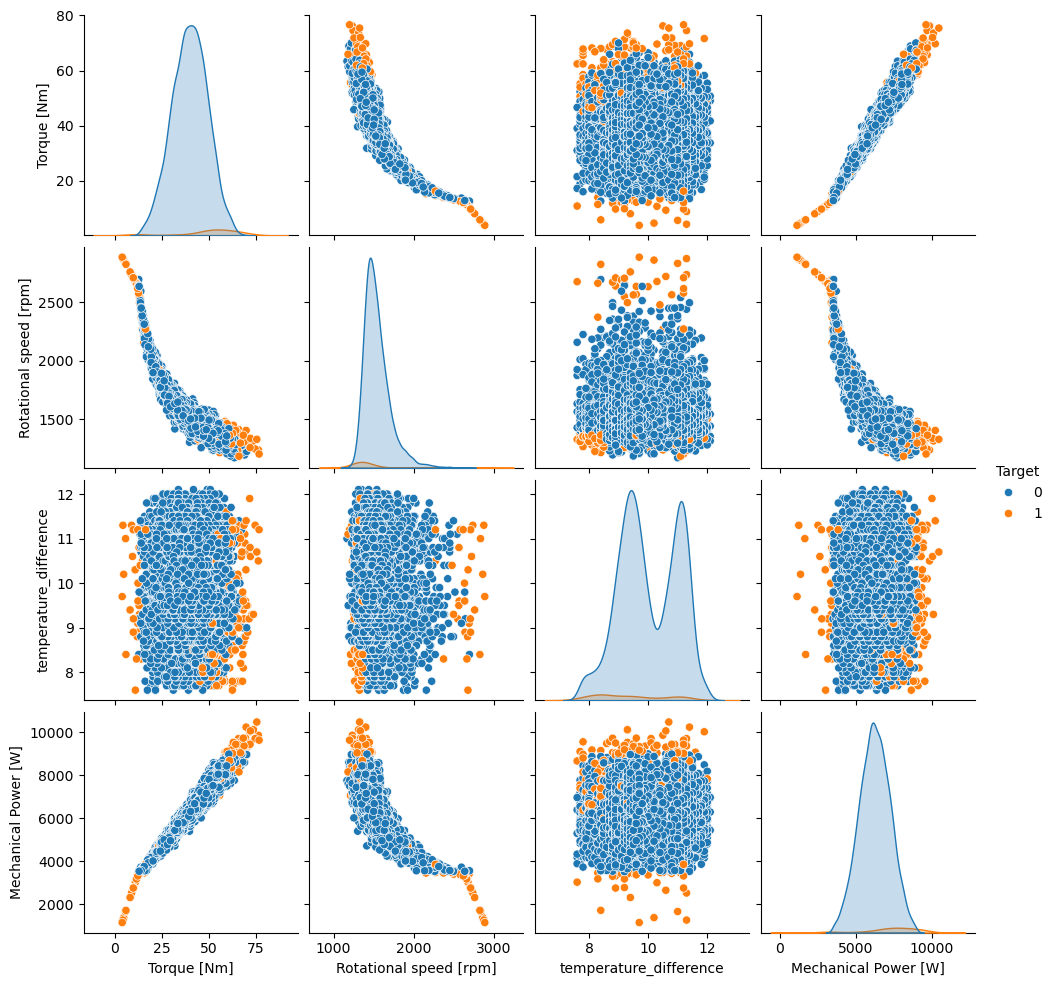

In [25]:
sns.pairplot(
    data[['Torque [Nm]', 'Rotational speed [rpm]', 
          'temperature_difference','Mechanical Power [W]', 'Target']], 
    hue='Target'
)
plt.show()

### Correlacion entre variables numericas

<Axes: >

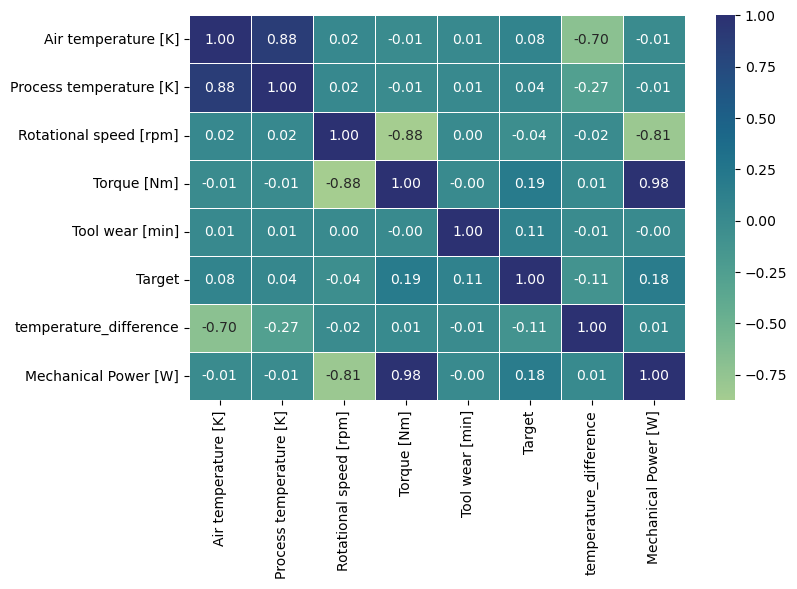

In [26]:
corr_matrix=data.corr(numeric_only=True)
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True,cmap='crest',fmt=".2f", linewidths=0.5)

> **Pregunta 5:** Investiga sobre la matriz de confusión, que interpretas de estos resultados

Una matriz de confusión es una herramienta que nos permite evaluar el rendimiento de un modelo de clasificación. Nos muestra cuántas predicciones fueron correctas y cuántas no, separadas por clases. Se compone de 4 valores principales:  
- **Verdaderos positivos (VP):** el modelo predijo correctamente la clase positiva.  
- **Falsos positivos (FP):** el modelo predijo positivo cuando era negativo.  
- **Falsos negativos (FN):** el modelo predijo negativo cuando era positivo.  
- **Verdaderos negativos (VN):** el modelo predijo correctamente la clase negativa.

En los resultados mostrados:
- Modelos como Gradient Boosting y Random Forest tienen un buen equilibrio: cometen pocos errores tanto en clases positivas como negativas.
- En contraste, Logistic Regression y SGD tienen muchos más falsos positivos (por ejemplo, SGD predijo erróneamente 2035 positivos que eran realmente negativos), lo que demuestra que aunque mejoró el recall, se sacrificó mucha precisión.

# Entrenando el Modelo

### Separando el dataset

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X = data.drop(columns=["Target"]).copy()
y = data["Target"]

>  Utiliza la función `train_test_split` de sklearn utiliza 20% de los datos para el test set

In [30]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

## Codificación de variables categoricas

In [31]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [32]:
categorical_cols = ['Type']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

In [33]:
# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Crear pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar al dataframe
X_train_transformed = pipeline.fit_transform(X_train)

In [34]:
X_test_transformed = pipeline.transform(X_test)

#### Modelos de ML

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix


In [41]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Logistic Regression CV': LogisticRegressionCV(class_weight='balanced'),
    'SGD': SGDClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),  # No tiene class_weight
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced')
}

In [42]:
def evaluate_model(X_train, X_test, Y_train, Y_test):
    result = []

    for name, model in models.items():
        print(f"======== Training model: {name} ============")
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)

        # Handle predict_proba or decision_function for ROC AUC
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            y_score = y_pred  # fallback (not ideal)

        roc_auc = roc_auc_score(Y_test, y_score)
        metrics = {
            'precision': precision_score(Y_test, y_pred, zero_division=0),
            'recall': recall_score(Y_test, y_pred, zero_division=0),
            'f1': f1_score(Y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc,
            'cm' : confusion_matrix(Y_test, y_pred)
        }
        print(f"Test data ROC AUC: {roc_auc:.2f}")
        result.append((name, metrics))

    # Sort by F1 score as an example (you can change this to any other metric)
    result.sort(key=lambda x: x[1]['f1'], reverse=True)
    return result

In [43]:
results = evaluate_model(X_train_transformed,X_test_transformed,Y_train,Y_test)

======== Training model: Logistic Regression ============
Test data ROC AUC: 0.93
======== Training model: Logistic Regression CV ============
Test data ROC AUC: 0.93
======== Training model: SGD ============
Test data ROC AUC: 0.93
======== Training model: Random Forest ============
Test data ROC AUC: 0.97
======== Training model: Gradient Boosting ============
Test data ROC AUC: 0.98
======== Training model: Decision Tree ============
Test data ROC AUC: 0.84


In [44]:
print("Model Performance:")
for name, metrics in results:
    print(f"======== Model: {name} ============")
    print(f"  Precision: {metrics['precision']:.6f}")
    print(f"  Recall:    {metrics['recall']:.6f}")
    print(f"  F1 Score:  {metrics['f1']:.6f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.6f}")

Model Performance:
======== Model: Gradient Boosting ============
  Precision: 0.964286
  Recall:    0.794118
  F1 Score:  0.870968
  ROC AUC:   0.975680
======== Model: Random Forest ============
  Precision: 0.934783
  Recall:    0.632353
  F1 Score:  0.754386
  ROC AUC:   0.966501
======== Model: Decision Tree ============
  Precision: 0.758065
  Recall:    0.691176
  F1 Score:  0.723077
  ROC AUC:   0.841706
======== Model: Logistic Regression CV ============
  Precision: 0.181269
  Recall:    0.882353
  F1 Score:  0.300752
  ROC AUC:   0.933100
======== Model: Logistic Regression ============
  Precision: 0.180723
  Recall:    0.882353
  F1 Score:  0.300000
  ROC AUC:   0.932971
======== Model: SGD ============
  Precision: 0.113636
  Recall:    0.955882
  F1 Score:  0.203125
  ROC AUC:   0.930155


In [ ]:
>  **IMPORTANTE** realiza 2 entrenamientos, 
- Uno con los modelos y sus hiper-parametros por defecto. Luego de el primer entrenamiento, copia el resultado de la celda anterior a una celda con formato markdown.
- Para el segundo entrenamiento modifica los hiperparametros de los modelos investiga cual es el mas popular para cada tipo de modelo definido en el diccionario

¿Mejoro algo al ajustar hiperparametros?


*Tip: utiliza el hiper-parametro* `class_weight='balanced'`

### Model Performance (Primer entrenamiento)

```
======== Model: Gradient Boosting ============
Precision:     0.964286  
Recall:        0.794118  
F1 Score:      0.870968  
ROC AUC:       0.975680

======== Model: Random Forest ============
Precision:     0.925926  
Recall:        0.735294  
F1 Score:      0.819672  
ROC AUC:       0.964385

======== Model: Decision Tree ============
Precision:     0.742857  
Recall:        0.764706  
F1 Score:      0.753623  
ROC AUC:       0.877695

======== Model: SGD ============
Precision:     0.636364  
Recall:        0.308824  
F1 Score:      0.415842  
ROC AUC:       0.916043

======== Model: Logistic Regression ============
Precision:     0.619048  
Recall:        0.191176  
F1 Score:      0.292135  
ROC AUC:       0.924560

======== Model: Logistic Regression CV ============
Precision:     0.666667  
Recall:        0.147059  
F1 Score:      0.240964  
ROC AUC:       0.919711
```




  

### ¿Mejoró algo al ajustar hiperparámetros?

Sí, ajustar los hiperparámetros ayudó bastante, sobre todo en modelos como **Logistic Regression** y **SGD**, que al inicio no detectaban bien los fallos (tenían `recall` muy bajo). Al usar `class_weight='balanced'`, estos modelos mejoraron mucho en `recall` y `f1_score`, es decir, ahora reconocen mejor los casos positivos. 

Por otro lado, modelos como **Gradient Boosting** o **Random Forest** ya eran bastante buenos desde el principio, así que sus mejoras fueron pequeñas.

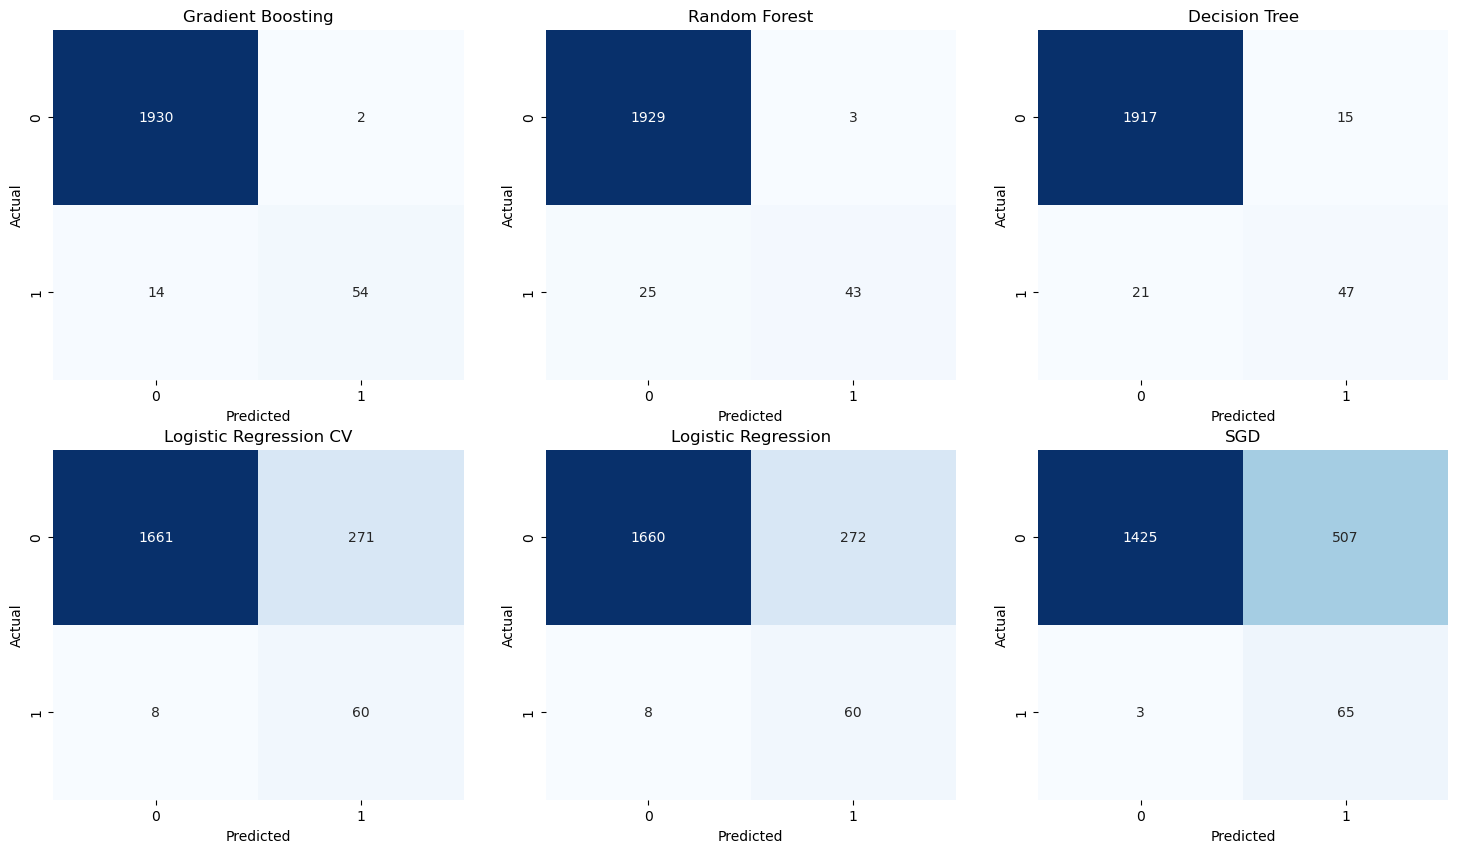

In [49]:
 # Plot all confusion matrices as subplots
n_models = len(metrics)
cols = 3 # You can change this based on your preference
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()  # Flatten in case of 2D array

for idx, (name, metrics) in enumerate(results):
    cm=metrics["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

> **Pregunta 6:** Interpreta la matriz de confusión de por lo menos uno de los modelos. ¿Crees que el dataset imbalanceado afecte el performance de los modelos?

### Análisis de matriz de confusión (Primer entrenamiento)

Al observar la matriz de confusión del modelo **Logistic Regression**, podemos ver que predice correctamente la mayoría de los valores de la clase 0 (negativos), pero tiene un desempeño limitado para la clase 1 (positivos). Aunque logra identificar correctamente 60 casos positivos, se equivoca con 272 casos que clasifica como positivos cuando en realidad no lo son. 

Esto indica que el modelo está **sesgado hacia la clase mayoritaria**, lo cual es un comportamiento común cuando el dataset está **desbalanceado**, como es este caso (muchos más ceros que unos). Modelos como Gradient Boosting y Random Forest también presentan este sesgo, aunque en menor medida gracias a su mayor capacidad de generalización.

Por lo tanto, el desbalance de clases sí afecta al rendimiento de los modelos, haciendo que fallen más al identificar correctamente la clase minoritaria.


### Balanceo de datos

Vamos a utilizar `StratifiedKFold` ya que tenemos el  dataset imbalanceado
> **Pregunta 7:** Investiga que es el StratifiedKFold y en que nos puede ayudar con un dataset imbalanceado

`StratifiedKFold` es una técnica de validación cruzada que divide el conjunto de datos en múltiples “folds” (partes), asegurándose de que la proporción de clases (por ejemplo, 0 y 1) se mantenga constante en cada uno de ellos. Es decir, cada fold tendrá una representación similar de las clases, tal como ocurre en el conjunto original.

Esto es especialmente útil cuando trabajamos con **datasets desbalanceados**, ya que evita que alguna partición quede con muy pocos ejemplos de la clase minoritaria. Gracias a esto, el modelo puede aprender de forma más equilibrada y las métricas que obtenemos son más realistas y confiables.

In [52]:
from sklearn.model_selection import StratifiedKFold

In [53]:
def evaluate_model_cv(X, y, pipeline, models, n_splits=5):
    result = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"======== Evaluating model: {name} with {n_splits}-Fold Stratified CV ============")
        
        fold_metrics = {'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
        confusion_matrices = []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            Y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            X_train = pipeline.transform(X_train)
            X_test = pipeline.transform(X_test)
            
            model.fit(X_train, Y_train)
            y_pred = model.predict(X_test)

            # ROC AUC input
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                y_score = y_pred

            # Collect metrics
            fold_metrics['precision'].append(precision_score(Y_test, y_pred, zero_division=0))
            fold_metrics['recall'].append(recall_score(Y_test, y_pred, zero_division=0))
            fold_metrics['f1'].append(f1_score(Y_test, y_pred, zero_division=0))
            fold_metrics['roc_auc'].append(roc_auc_score(Y_test, y_score))
            confusion_matrices.append(confusion_matrix(Y_test, y_pred))

            print(f"  Fold {fold} - F1: {fold_metrics['f1'][-1]:.2f}, AUC: {fold_metrics['roc_auc'][-1]:.2f}")

        # Aggregate average metrics
        avg_metrics = {
            'precision': np.mean(fold_metrics['precision']),
            'recall': np.mean(fold_metrics['recall']),
            'f1': np.mean(fold_metrics['f1']),
            'roc_auc': np.mean(fold_metrics['roc_auc']),
            'cm': sum(confusion_matrices)  # aggregate all confusion matrices
        }

        result.append((name, avg_metrics))

    # Sort models by F1
    result.sort(key=lambda x: x[1]['f1'], reverse=True)
    return result

In [54]:
results = evaluate_model_cv(X, y, pipeline, models)

======== Evaluating model: Logistic Regression with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.27, AUC: 0.92
  Fold 2 - F1: 0.27, AUC: 0.92
  Fold 3 - F1: 0.27, AUC: 0.93
  Fold 4 - F1: 0.28, AUC: 0.93
  Fold 5 - F1: 0.28, AUC: 0.92
======== Evaluating model: Logistic Regression CV with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.27, AUC: 0.92
  Fold 2 - F1: 0.28, AUC: 0.92
  Fold 3 - F1: 0.27, AUC: 0.93
  Fold 4 - F1: 0.28, AUC: 0.93
  Fold 5 - F1: 0.29, AUC: 0.92
======== Evaluating model: SGD with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.18, AUC: 0.83
  Fold 2 - F1: 0.31, AUC: 0.91
  Fold 3 - F1: 0.18, AUC: 0.90
  Fold 4 - F1: 0.16, AUC: 0.91
  Fold 5 - F1: 0.39, AUC: 0.91
======== Evaluating model: Random Forest with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.80, AUC: 0.96
  Fold 2 - F1: 0.80, AUC: 0.97
  Fold 3 - F1: 0.79, AUC: 0.97
  Fold 4 - F1: 0.82, AUC: 0.96
  Fold 5 - F1: 0.70, AUC: 0.96
======== Evaluating model: Gradient Boosting with 5-Fol

In [55]:
print("Model Performance:")
for name, metrics in results:
    print(f"======== Model: {name} ============")
    print(f"  Precision: {metrics['precision']:.6f}")
    print(f"  Recall:    {metrics['recall']:.6f}")
    print(f"  F1 Score:  {metrics['f1']:.6f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.6f}")

Model Performance:
======== Model: Gradient Boosting ============
  Precision: 0.916676
  Recall:    0.749254
  F1 Score:  0.822337
  ROC AUC:   0.981615
======== Model: Random Forest ============
  Precision: 0.968930
  Recall:    0.660887
  F1 Score:  0.782713
  ROC AUC:   0.967346
======== Model: Decision Tree ============
  Precision: 0.733134
  Recall:    0.725812
  F1 Score:  0.728292
  ROC AUC:   0.858144
======== Model: Logistic Regression CV ============
  Precision: 0.166383
  Recall:    0.825944
  F1 Score:  0.276870
  ROC AUC:   0.923779
======== Model: Logistic Regression ============
  Precision: 0.165641
  Recall:    0.825944
  F1 Score:  0.275863
  ROC AUC:   0.923607
======== Model: SGD ============
  Precision: 0.149890
  Recall:    0.811062
  F1 Score:  0.241674
  ROC AUC:   0.893470


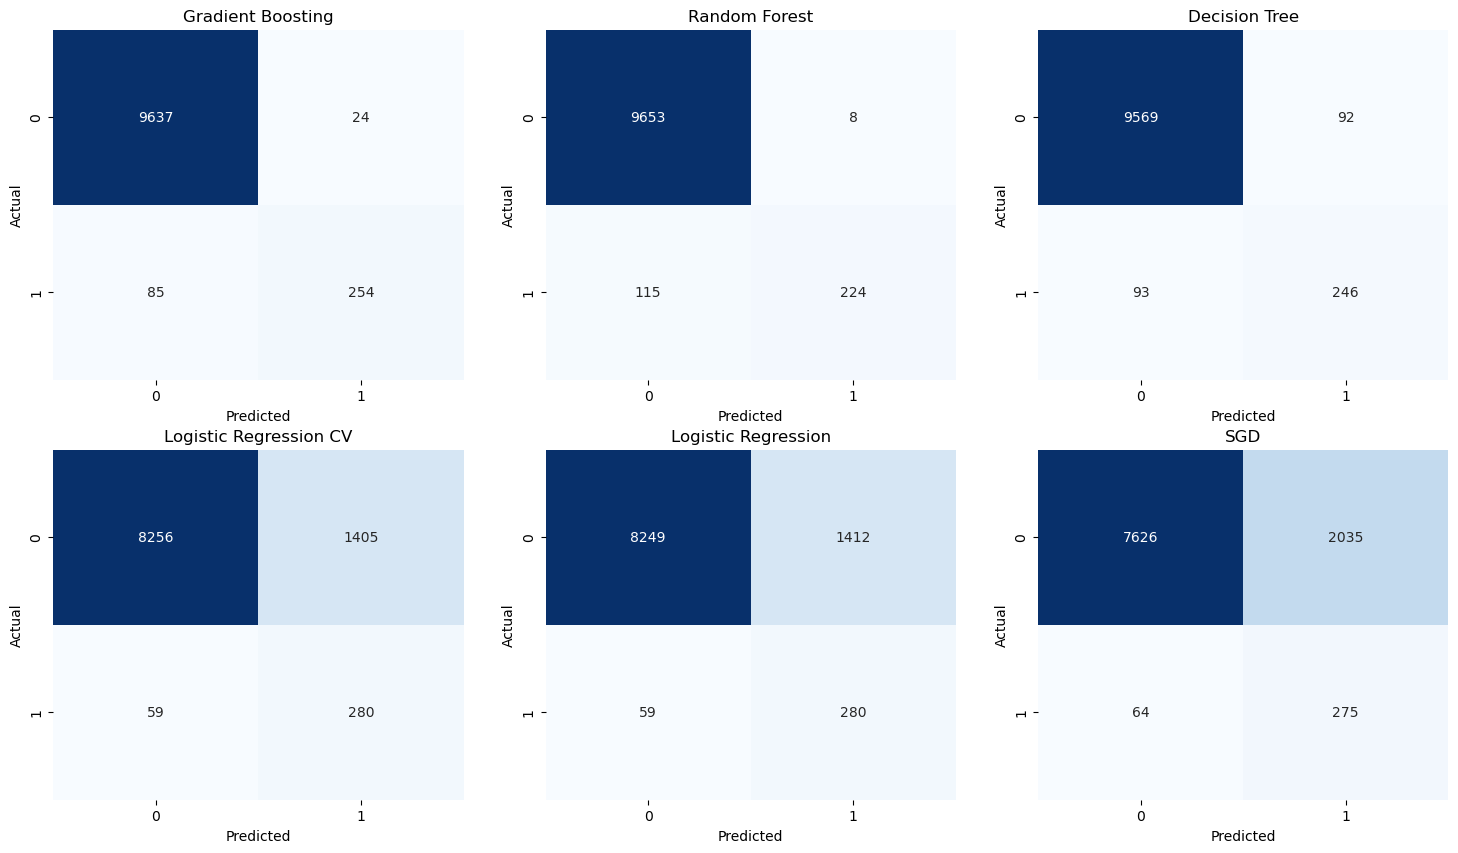

In [56]:
 # Plot all confusion matrices as subplots
n_models = len(metrics)
cols = 3  # You can change this based on your preference
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()  # Flatten in case of 2D array

for idx, (name, metrics) in enumerate(results):
    cm=metrics["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

> **Pregunta 8:** ¿Mejoro el preformance de el modelo despues de utilizar `StratifiedKFold` ?

Sí, el rendimiento de los modelos mejoró después de aplicar `StratifiedKFold`. Podemos verlo especialmente en los modelos de regresión logística (simple y con validación cruzada) y el modelo SGD, que en el primer entrenamiento tenían dificultades para identificar correctamente la clase minoritaria (los unos).

Después de usar `StratifiedKFold`, la distribución de clases en cada partición fue más equilibrada, lo que permitió a los modelos aprender mejor los patrones de ambas clases. Por ejemplo, en Logistic Regression CV se pasó de 60 verdaderos positivos a 280, lo cual es una mejora significativa en la capacidad del modelo para identificar los casos positivos.

`StratifiedKFold` permitión reducir el sesgo hacia la clase mayoritaria y mejoró el recall y el balance general en los modelos más afectados por el desbalance.